In [1]:
from conditional_inference.bayes.empirical_bayes import JamesStein
from conditional_inference.conventional import ConventionalModel
from conditional_inference.quantile_unbiased.rqu import RQU

import os
import re
import warnings
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dask import delayed
from dask.distributed import Client

np.random.seed(123)

filenames = [
    ("pennmed", "penn_medicine_reconstructed.csv"),
    ("walmart", "walmart_reconstructed.csv"),
]
datapath = "../data"
# number of simulations to run
n_simulations = 1
# number of observations per batch
batch_size = 250
# total number of participants to run (may be less depending on rounding)
n_participants = 128000
# minimum number of participants at which to start collecting performance metrics
start_metrics = 2000
# indicates that you should test each cell as you run the notebook
run_tests = False

# define the batch intervals at which to collect metrics
n_batches = int(n_participants / batch_size)
start_metrics = int(start_metrics / batch_size)
collect_metrics = []
i = 0
while not collect_metrics or collect_metrics[-1] <= n_batches:
    collect_metrics.append(start_metrics * 2**i)
    i += 1
collect_metrics = collect_metrics[:-1]
n_batches = collect_metrics[-1]

# client = Client(n_workers=4)
sns.set()

In [2]:
batch_size * n_batches

128000

In [3]:
def return_X_y(filename):
    # return one-hot encoded feature matrix X (n_obs, n_arms) and target vector y (n_obs,)
    df = pd.read_csv(os.path.join(datapath, filename))
    if "control" in df:
        df = df[df.control == 0]
    bootstrap_df = df.groupby("arm").apply(lambda df: df.sample(frac=1, replace=True))
    bootstrap_df = bootstrap_df.drop(columns="arm").reset_index()
    return pd.get_dummies(bootstrap_df.arm), bootstrap_df.y

if run_tests:
    X, y = return_X_y(filenames[0])
    print(X.head())

In [4]:
def compute_sample_weight(X, y):
    # return "true" mean vector (n_arms,) and weight matrix W (n_obs, n_arms)
    # W[i, k] is the probability that you sample label i when assigning a participant to arm k
    result = sm.OLS(y, X).fit().get_robustcov_results()
    mean, cov = result.params, result.cov_params()
    mean_bar = mean.mean()
    tau = ((mean - mean_bar)**2).sum() / (mean.shape[0] - 3) * np.identity(mean.shape[0])
    projection = np.ones((mean.shape[0], mean.shape[0])) / mean.shape[0]
    weight_matrix = cov @ np.linalg.inv(tau) @ (projection - np.identity(mean.shape[0])) + np.identity(mean.shape[0])
    sample_weight = weight_matrix.repeat(X.sum(axis=0), axis=1).T / X.sum(axis=0).values
    return weight_matrix @ mean, sample_weight

if run_tests:
    true_mean, sample_weight = compute_sample_weight(X, y)
    print(true_mean, sample_weight.shape)

In [5]:
def assign_participants(assignment_weight, y, sample_weight, X_sample=None, y_sample=None, n_obs=batch_size):
    # assignment_weight (n_arms,) is the proportion of participants assigned to each arm
    # n_obs is the total number of participants to assign
    assignment_weight = assignment_weight / assignment_weight.sum()
    K = assignment_weight.shape[0]
    n_obs_per_arm = np.floor(n_obs * assignment_weight)
    remaining_obs = np.random.choice(np.arange(K), size=int(n_obs-n_obs_per_arm.sum()), p=assignment_weight)
    n_obs_per_arm = (n_obs_per_arm + np.identity(K)[remaining_obs].sum(axis=0)).astype(int)

    y_new = []
    for k in range(K):
        y_new += y.sample(n=n_obs_per_arm[k], replace=True, weights=sample_weight[:, k]).tolist()
    X_new = np.identity(K).repeat(n_obs_per_arm, axis=0)

    if X_sample is None:
        return X_new, np.array(y_new)
    return np.concatenate((X_sample, X_new), axis=0), np.concatenate((y_sample, y_new))

if run_tests:
    assignment_weight = np.ones(true_mean.shape[0])
    X_sample, y_sample = assign_participants(assignment_weight, y, sample_weight, n_obs=10000)
    print(X_sample.shape, y_sample.shape)

In [6]:
def compute_metrics(X, y):
    ols_results = sm.OLS(y, X).fit().get_robustcov_results()
    metrics = dict(
        n_obs=y.shape[0],
        recommended_arm=ols_results.params.argmax(),
        cum_value=y.sum(),
    )
    try:
        beta = .005
        alpha = (.05 - beta) / (1 - beta)
        rqu_dist = RQU.from_results(ols_results).get_distribution(beta=beta)
        metrics.update(dict(
            median=rqu_dist.median(),
            ppf025=rqu_dist.ppf(alpha / 2),
            ppf975=rqu_dist.ppf(1 - alpha / 2),
            mdb=rqu_dist.ppf(alpha),
        ))
    except:
        pass
    return metrics

if run_tests:
    print(compute_metrics(X_sample, y_sample))

In [7]:
def random_assignment(X, y, sample_weight):
    results = []
    assignment_weight = np.ones(X.shape[1])
    X_sample, y_sample = None, None
    total_batches = start_metrics
    prev_total_batches = 0
    i = 0
    while total_batches <= n_batches:
        i += 1
        n_obs = batch_size * (total_batches - prev_total_batches)
        prev_total_batches = total_batches
        total_batches = start_metrics * 2**i

        X_sample, y_sample = assign_participants(assignment_weight, y, sample_weight, X_sample=X_sample, y_sample=y_sample, n_obs=n_obs)
        results.append(compute_metrics(X_sample, y_sample))

    return results

if run_tests:
    print(random_assignment(X, y, sample_weight))

In [ ]:
# TODO: incorporate successive rejects into simulations

def successive_rejections(mu_treat, n_treat_observations):
    def run_round(n_ik):
        n_ik = int(n_ik)
        X = np.identity(mu_treat.shape[0])[A].repeat(n_ik, axis=0)
        y = np.array([
            bernoulli(mu_i).rvs(n_ik) 
            for i, mu_i in enumerate(mu_treat) if i in A
        ]).reshape(-1)
        return X, y

    K = mu_treat.shape[0]
    logK = .5 + sum([1/i for i in range(2, K+1)])
    n_k = np.array([
        np.ceil(1/logK * (n_treat_observations-K)/(K+1-i))
        for i in range(1, K)
    ])
    n_k = np.diff(np.insert(n_k, 0, 0))
    A = np.arange(K)
    X, y = None, None
    for n_ik in n_k:
        X_k, y_k = run_round(n_ik)
        if X is None:
            X, y = X_k, y_k
        else:
            X = np.concatenate((X, X_k))
            y = np.concatenate((y, y_k))
        # drop worst remaining arm
        mu_hat = (X.T * y).mean(axis=1)
        A = A[A!=np.where(mu_hat == mu_hat[A].min())[0][0]]
    return X, y

In [8]:
def exploration_sampling(X, y, sample_weight, estimate_pr_bestarm):
    results = []
    assignment_weight = np.ones(X.shape[1])
    X_sample, y_sample = None, None
    for i in range(n_batches):
        X_sample, y_sample = assign_participants(assignment_weight, y, sample_weight, X_sample=X_sample, y_sample=y_sample)
        ols_results = sm.OLS(y_sample, X_sample).fit().get_robustcov_results()
        pr_bestarm = estimate_pr_bestarm(ols_results)
        assignment_weight = pr_bestarm * (1 - pr_bestarm)
        if i+1 in collect_metrics:
            results.append(compute_metrics(X_sample, y_sample))

    return results

def mle_bestarm(ols_results):
    try:
        mle_results = ConventionalModel.from_results(ols_results).fit()
        return mle_results.rank_matrix.values[0]
    except:
        # most likely error is that matrix isn't invertible => all arms equally likely to be best
        return np.full(ols_results.params.shape, 1/ols_results.params.shape[0])

def js_bestarm(ols_results):
    with warnings.catch_warnings(record=True):
        warnings.simplefilter("error")
        try:
            js_results = JamesStein.from_results(ols_results).fit()
            return js_results.rank_matrix.values[0]
        except:
            # JamesStein prior is approximately 0 ==> all arms are equally likely to be best
            return np.full(ols_results.params.shape, 1/ols_results.params.shape[0])

exploration_sampling_mle = partial(exploration_sampling, estimate_pr_bestarm=mle_bestarm)
exploration_sampling_js = partial(exploration_sampling, estimate_pr_bestarm=js_bestarm)

if run_tests:
    print(exploration_sampling_mle(X, y, sample_weight), exploration_sampling_js(X, y, sample_weight))

In [9]:
assignment_strategies = [
    ("randomassignment", random_assignment),
    ("explorationsamplingMLE", exploration_sampling_mle),
    ("exploration_samplingJS", exploration_sampling_js)
]

In [10]:
%%time

@delayed
def run_simulation(filename, strategy, sim_no=0):
    np.random.seed(sim_no)
    strategy_name, strategy = strategy
    file_shortname, filename = filename
    sample_weight, i = None, 0
    while sample_weight is None or (sample_weight < 0).any():
        # use bootstrapping to get feature matrix and target vector
        # X is (n_obs, n_arms) one-hot encoded matrix, y is (n_obs,) target vector
        X, y = return_X_y(filename)
        # true_mean is (n_arms,) vector of "true" means for the sample
        # sample_weight is (n_obs, n_arms) where sample_weight[i, k] is the weight observation i gets when assigning a participants to arm k
        true_mean, sample_weight = compute_sample_weight(X, y)
        i += 1
        if i == 100:
            print("Failed to find suitable sample weights")
            return pd.DataFrame()

    
    df = pd.DataFrame(strategy(X, y, sample_weight))
    df["strategy"] = strategy_name
    df["filename"] = file_shortname
    df["sim_no"] = sim_no
    df["recommended_rank"] = df.recommended_arm.apply(lambda idx: (true_mean > true_mean[idx]).sum())
    df["recommended_value"] = true_mean[df.recommended_arm]
    df["best_value"] = true_mean.max()
    if not os.path.exists("results"):
        os.mkdir("results")
    df.to_csv(f"results/results_{file_shortname}_{strategy_name}_{sim_no}.csv", index=False)
    return df

if run_tests:
    run_simulation(filenames[0], assignment_strategies[0]).compute()

Wall time: 0 ns


In [13]:
%%time

df = delayed(pd.concat)([
    run_simulation(filename, strategy, sim_no)
    for (filename, strategy, sim_no) in product(filenames, assignment_strategies, range(n_simulations))
]).compute()
df.head()

Wall time: 1min 9s


n_obs  recommended_arm  cum_value    median    ppf025    ppf975       mdb  \
0   2000               18        876  0.409793  0.323521  0.596721  0.323521   
1   4000                8       1740  0.376369  0.362428  0.538367  0.362428   
2   8000               16       3486  0.470791  0.392599  0.533903  0.400461   
0   2000                0        815  0.253754  0.252176  0.390793  0.252176   
1   4000                3       1720  0.362670  0.343539  0.532666  0.343539   

                 strategy filename  sim_no  recommended_rank  \
0        randomassignment  pennmed       0                12   
1        randomassignment  pennmed       0                 3   
2        randomassignment  pennmed       0                10   
0  explorationsamplingMLE  pennmed       0                 4   
1  explorationsamplingMLE  pennmed       0                 6   

   recommended_value  best_value  
0           0.429708    0.446635  
1           0.443515    0.446635  
2           0.435309    0.446635  
0           0.443275    0.446635  
1           0.439663    0.446635

In [29]:
df["expost_regret"] = df.best_value - df.recommended_value
df["cum_regret"] = df.n_obs * df.best_value - df.cum_value
df["len_ci"] = df.ppf975 - df.ppf025
df["abs_error"] = abs(df["median"] - df.recommended_value)
df["coverage"] = (df.ppf025 <= df.recommended_value) & (df.recommended_value <= df.ppf975)
df["fpr"] = df.recommended_value < df.mdb
df.head()

n_obs  recommended_arm  cum_value    median    ppf025    ppf975       mdb  \
0   3000                1       1310  0.481013  0.336851  0.437969  0.336851   
1   6000               10       2630  0.396682  0.380470  0.529118  0.380470   
2   3000                9       1318  0.349751  0.349037  0.410043  0.349037   
3   6000                9       2631  0.436216  0.393912  0.494337  0.393912   
4   3000                4       1306  0.500000  0.500000  0.500000  0.500000   

                   strategy                         filename  sim_no  \
0         random_assignment  penn_medicine_reconstructed.csv       0   
1         random_assignment  penn_medicine_reconstructed.csv       0   
2  exploration_sampling_mle  penn_medicine_reconstructed.csv       0   
3  exploration_sampling_mle  penn_medicine_reconstructed.csv       0   
4   exploration_sampling_js  penn_medicine_reconstructed.csv       0   

   recommended_rank  recommended_value  best_value  expost_regret  cum_regret  \
0                 0           0.450828    0.450828       0.000000   42.485489   
1                 5           0.445794    0.450828       0.005034   74.970978   
2                 7           0.439904    0.450828       0.010925   34.485489   
3                 7           0.439904    0.450828       0.010925   73.970978   
4                10           0.436527    0.450828       0.014301   46.485489   

     len_ci  abs_error  coverage    fpr  
0  0.101117   0.030184     False  False  
1  0.148648   0.049112      True  False  
2  0.061006   0.090153     False  False  
3  0.100424   0.003688      True  False  
4  0.000000   0.063473     False   True

In [30]:
mean_metrics = [
    "recommended_value",
    "cum_value",
    "expost_regret",
    "cum_regret",
    "mdb",
    "coverage",
    "fpr",
]

quantile_metrics = [
    "recommended_rank",
    "recommended_value",
    "cum_value",
    "expost_regret",
    "cum_regret",
    "mdb",
    "abs_error",
    "len_ci",
]

In [31]:
df.groupby(["filename", "n_obs", "strategy"])[mean_metrics].mean()

recommended_value  \
filename                        n_obs strategy                                      
penn_medicine_reconstructed.csv 3000  exploration_sampling_js            0.437923   
                                      exploration_sampling_mle           0.438825   
                                      random_assignment                  0.441753   
                                6000  exploration_sampling_js            0.448517   
                                      exploration_sampling_mle           0.443154   
                                      random_assignment                  0.449139   
walmart_reconstructed.csv       3000  exploration_sampling_js            0.246248   
                                      exploration_sampling_mle           0.248127   
                                      random_assignment                  0.245158   
                                6000  exploration_sampling_js            0.247759   
                                      exploration_sampling_mle           0.247473   
                                      random_assignment                  0.248376   

                                                                  cum_value  \
filename                        n_obs strategy                                
penn_medicine_reconstructed.csv 3000  exploration_sampling_js   1314.000000   
                                      exploration_sampling_mle  1320.666667   
                                      random_assignment         1307.666667   
                                6000  exploration_sampling_js   2624.000000   
                                      exploration_sampling_mle  2631.666667   
                                      random_assignment         2597.000000   
walmart_reconstructed.csv       3000  exploration_sampling_js    730.000000   
                                      exploration_sampling_mle   738.000000   
                                      random_assignment          732.000000   
                                6000  exploration_sampling_js   1473.333333   
                                      exploration_sampling_mle  1452.666667   
                                      random_assignment         1442.000000   

                                                                expost_regret  \
filename                        n_obs strategy                                  
penn_medicine_reconstructed.csv 3000  exploration_sampling_js        0.015169   
                                      exploration_sampling_mle       0.014268   
                                      random_assignment              0.011340   
                                6000  exploration_sampling_js        0.004575   
                                      exploration_sampling_mle       0.009939   
                                      random_assignment              0.003953   
walmart_reconstructed.csv       3000  exploration_sampling_js        0.007290   
                                      exploration_sampling_mle       0.005411   
                                      random_assignment              0.008380   
                                6000  exploration_sampling_js        0.005778   
                                      exploration_sampling_mle       0.006065   
                                      random_assignment              0.005162   

                                                                cum_regret  \
filename                        n_obs strategy                               
penn_medicine_reconstructed.csv 3000  exploration_sampling_js    45.277256   
                                      exploration_sampling_mle   38.610590   
                                      random_assignment          51.610590   
                                6000  exploration_sampling_js    94.554513   
                                      exploration_sampling_mle   86.887846   
                                      random_assignment         121.554513   
walmart

In [32]:
df.groupby(["filename", "n_obs", "strategy"])[quantile_metrics].quantile([.05, .5, .95])

recommended_rank  \
filename                        n_obs strategy                                          
penn_medicine_reconstructed.csv 3000  exploration_sampling_js  0.05               2.8   
                                                               0.50              10.0   
                                                               0.95              14.5   
                                      exploration_sampling_mle 0.05               6.1   
                                                               0.50               7.0   
                                                               0.95               8.8   
                                      random_assignment        0.05               0.7   
                                                               0.50               7.0   
                                                               0.95              12.4   
                                6000  exploration_sampling_js  0.05               1.0   
                                                               0.50               1.0   
                                                               0.95               5.5   
                                      exploration_sampling_mle 0.05               1.5   
                                                               0.50               6.0   
                                                               0.95               6.9   
                                      random_assignment        0.05               1.0   
                                                               0.50               1.0   
                                                               0.95               4.6   
walmart_reconstructed.csv       3000  exploration_sampling_js  0.05               0.5   
                                                               0.50               5.0   
                                                               0.95              18.5   
                                      exploration_sampling_mle 0.05               2.4   
                                                               0.50               6.0   
                                                               0.95              12.3   
                                      random_assignment        0.05               9.1   
                                                               0.50              10.0   
                                                               0.95              17.2   
                                6000  exploration_sampling_js  0.05               0.9   
                                                               0.50               9.0   
                                                               0.95              12.6   
                                      exploration_sampling_mle 0.05               5.2   
                                                               0.50               7.0   
                                                               0.95              13.3   
                                      random_assignment        0.05               4.5   
                                                               0.50               9.0   
                                                               0.95               9.0   

                                                                     recommended_value  \
filename                        n_obs strategy                                           
penn_medicine_reconstructed.csv 3000  exploration_sampling_js  0.05           0.429006   
                                                               0.50           0.436527   
                                                               0.95           0.447817   
                                      exploration_sampling_mle 0.05           0.437626   
                                                               0.50           0.439108   
                                                        

In [33]:
def lineplot(y, quantile=None):
    if quantile is None:
        estimator = "mean"
        title = "Mean"
    else:
        estimator = lambda x: np.quantile(x, q=quantile)
        title = f"Quantile {quantile}"
    rp = sns.relplot(
        data=df, 
        x="n_obs", 
        y=y, 
        hue="strategy", 
        col="filename", 
        ci=None, 
        estimator=estimator, 
        kind="line", 
        facet_kws=dict(sharey=False)
    )
    rp.set(xscale="log")
    rp.fig.subplots_adjust(top=.9)
    rp.fig.suptitle(title)
    return rp

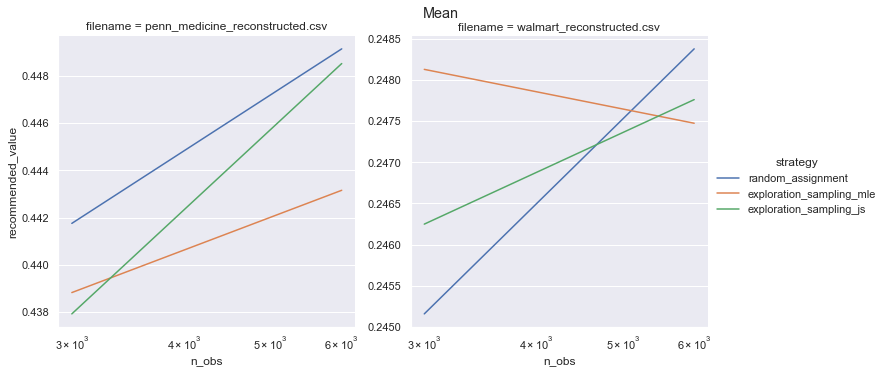

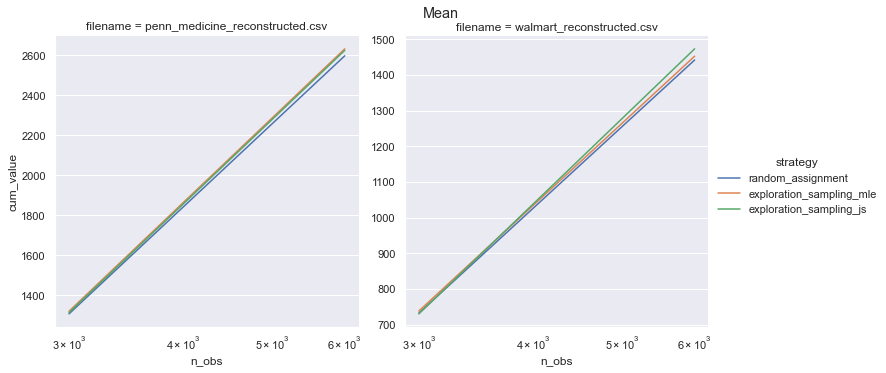

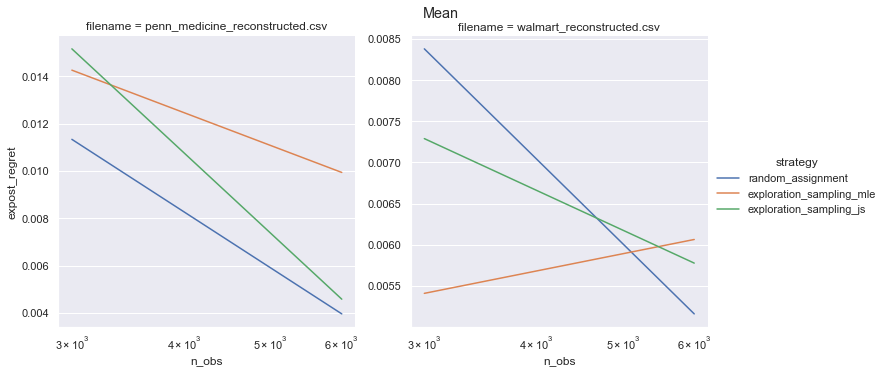

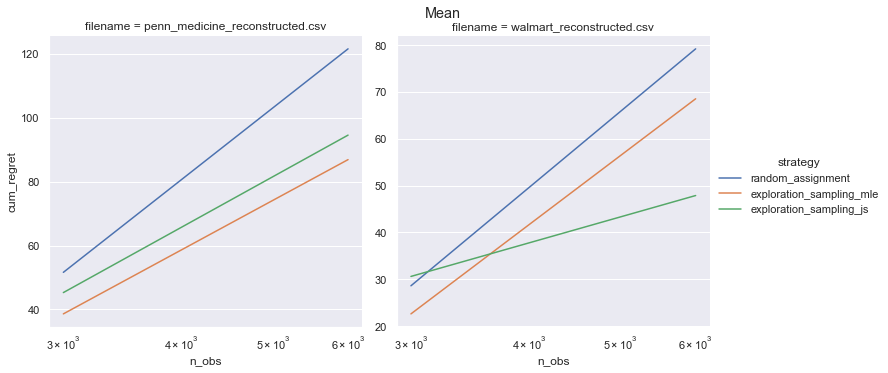

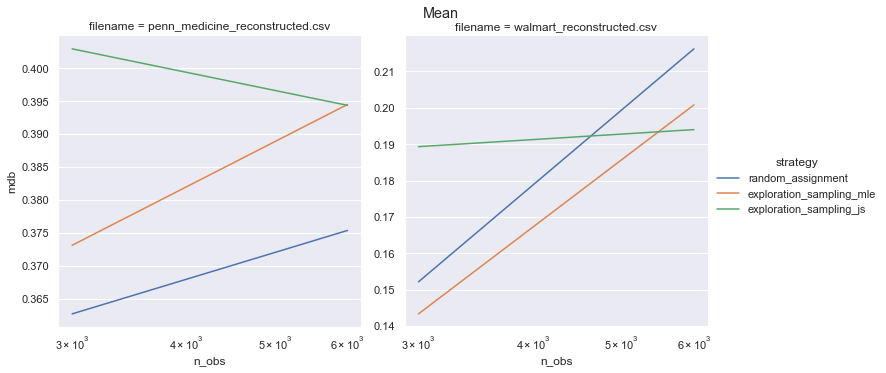

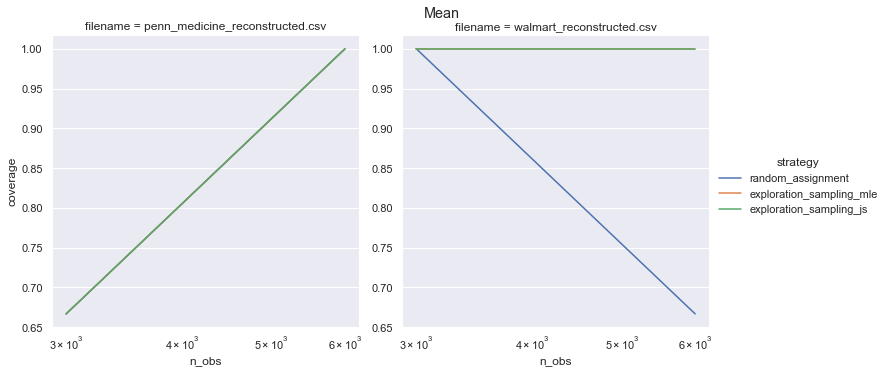

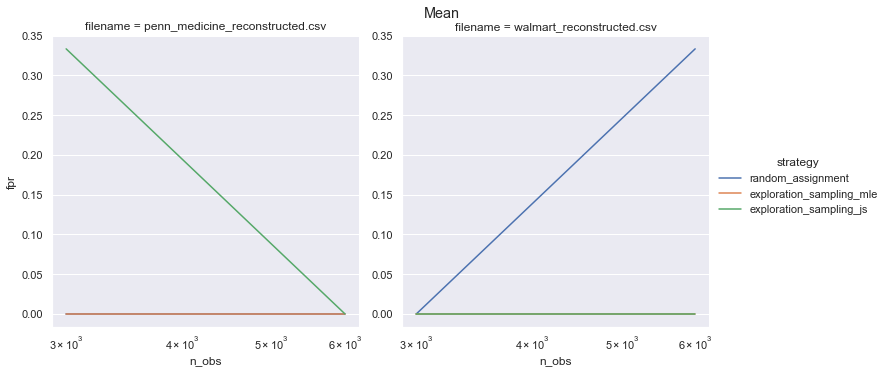

In [34]:
for var in mean_metrics:
    lineplot(var)
    plt.show()

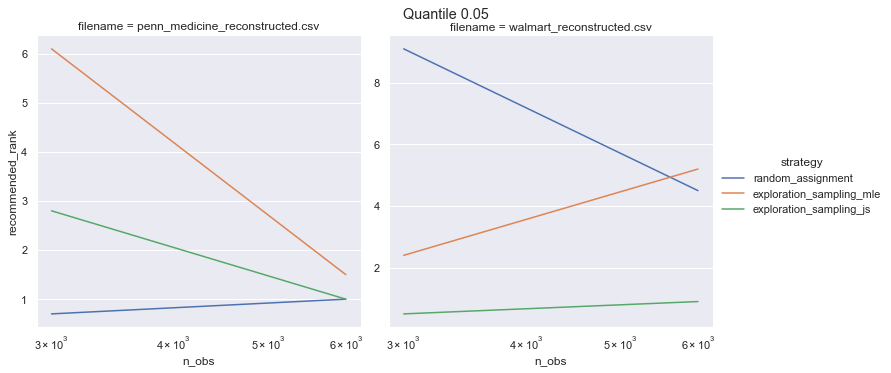

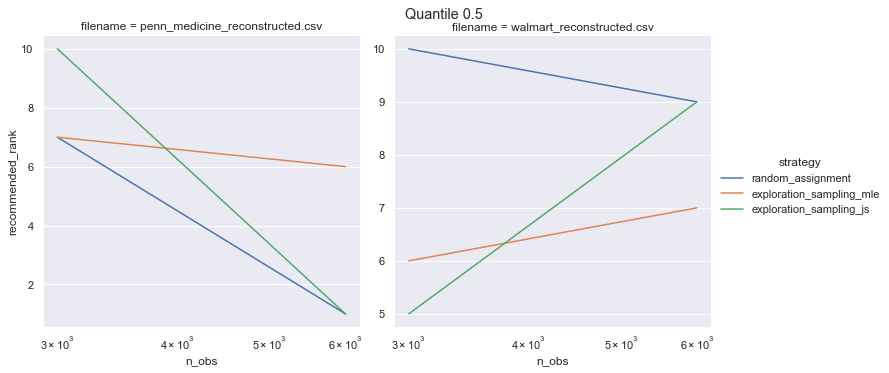

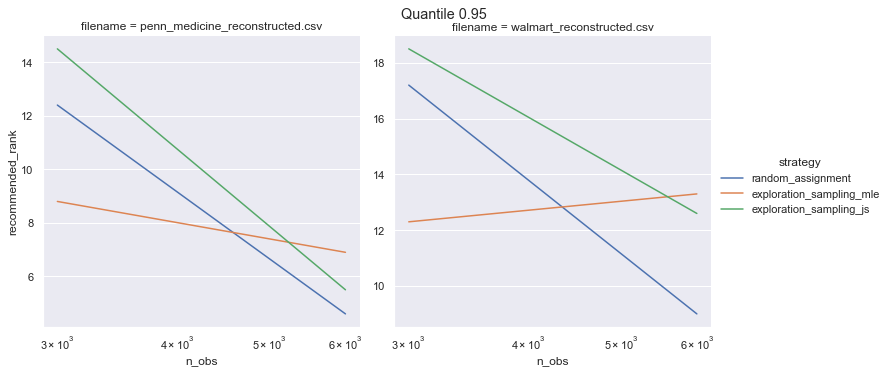

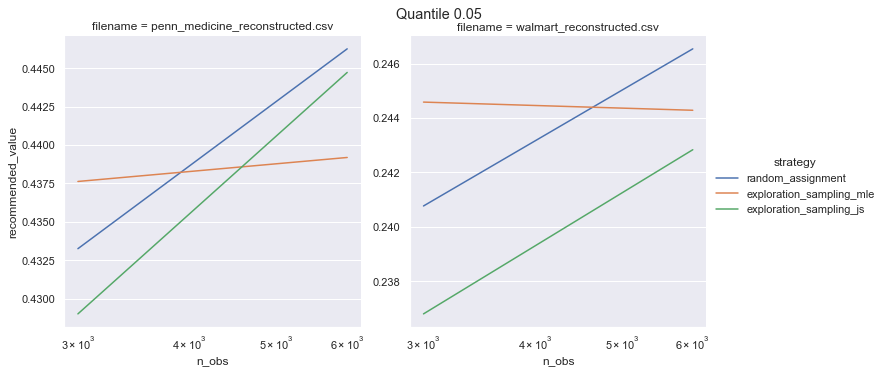

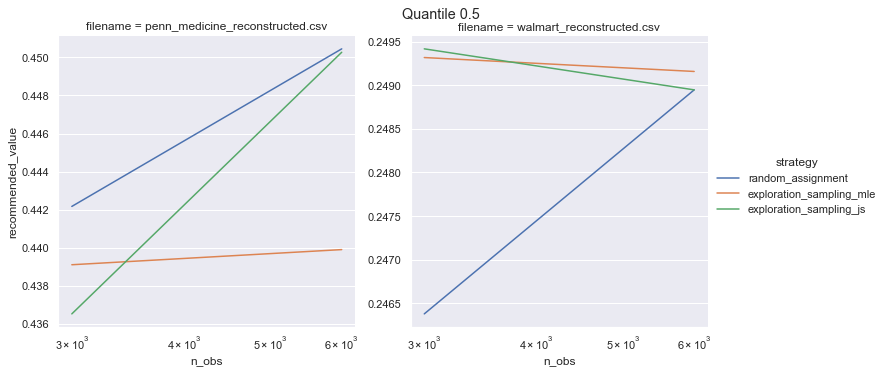

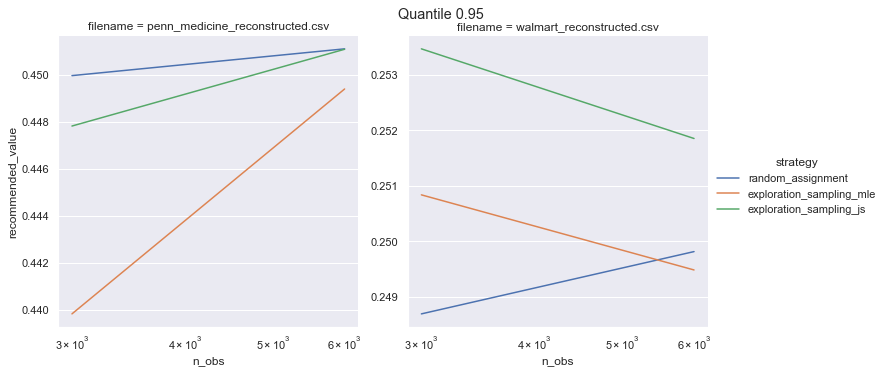

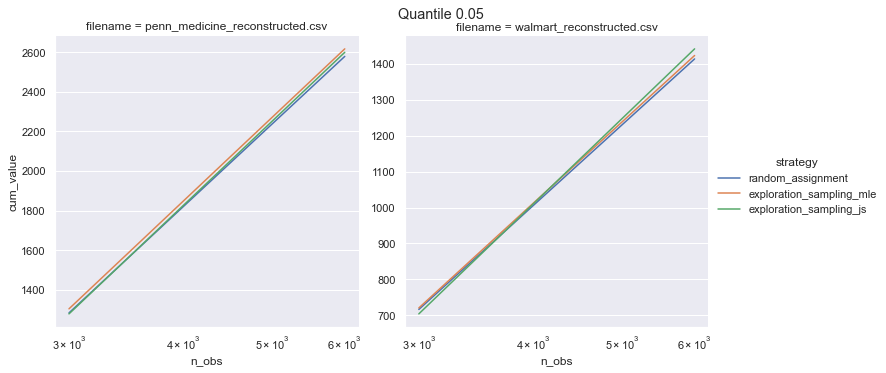

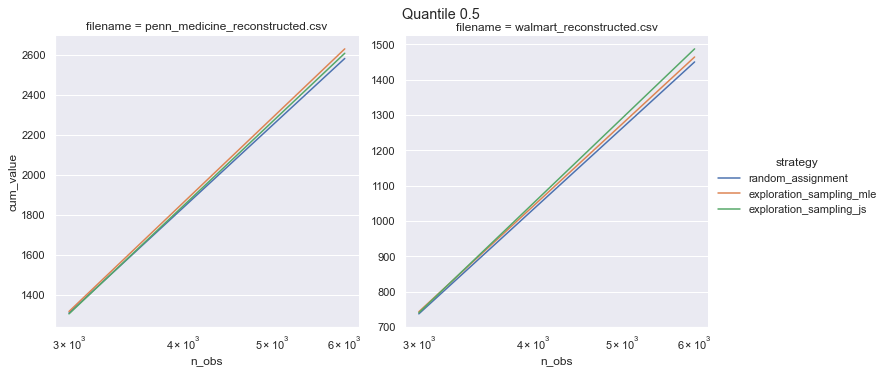

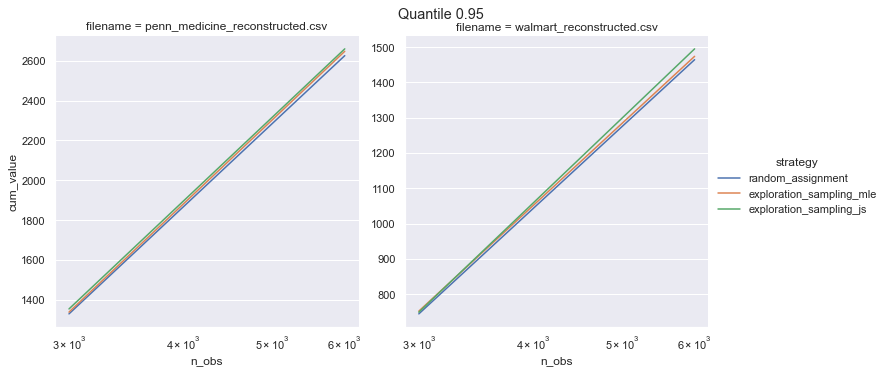

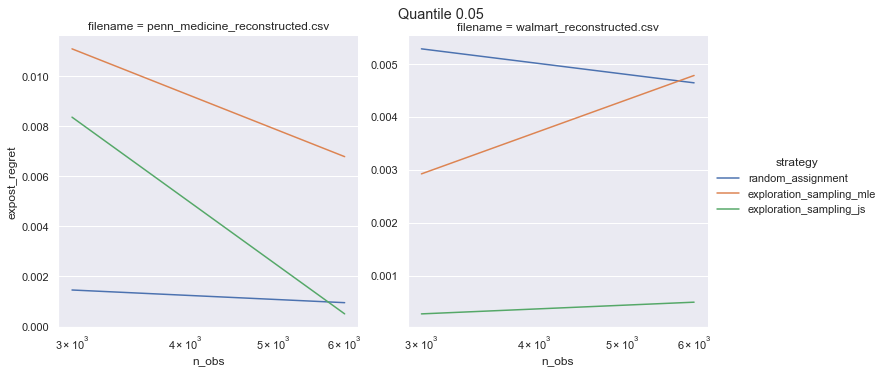

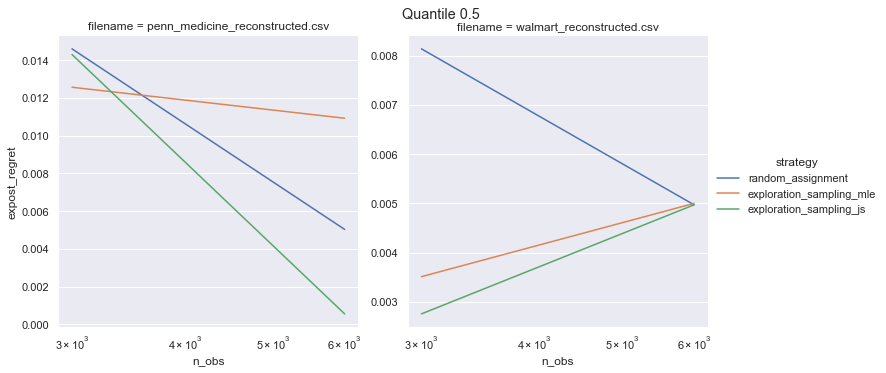

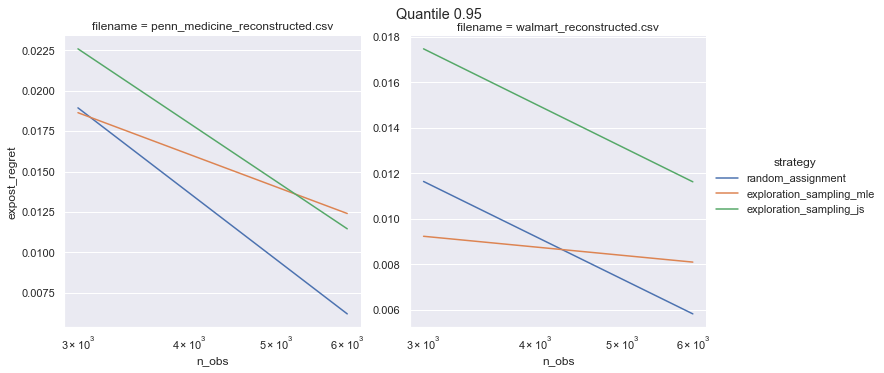

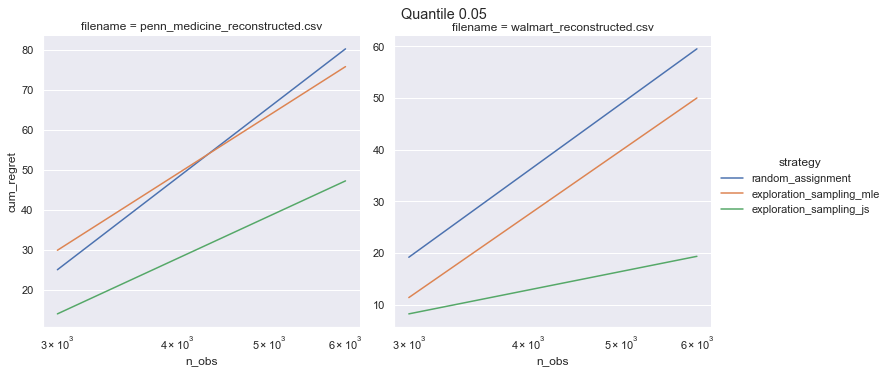

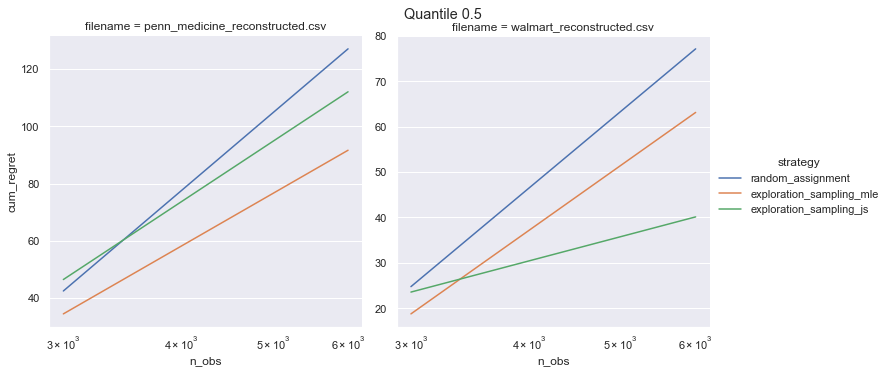

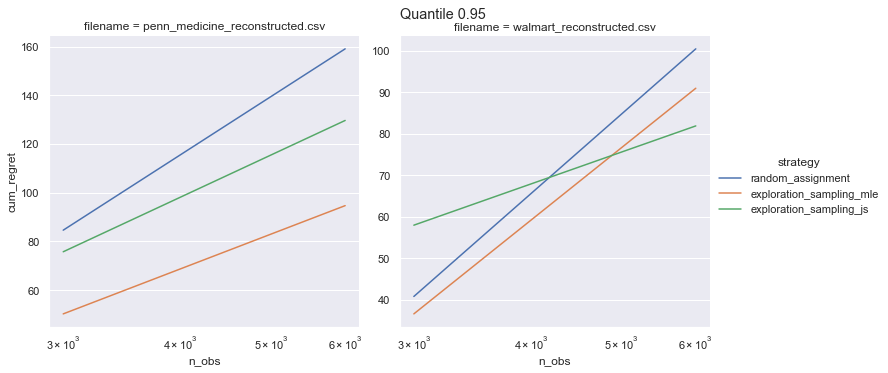

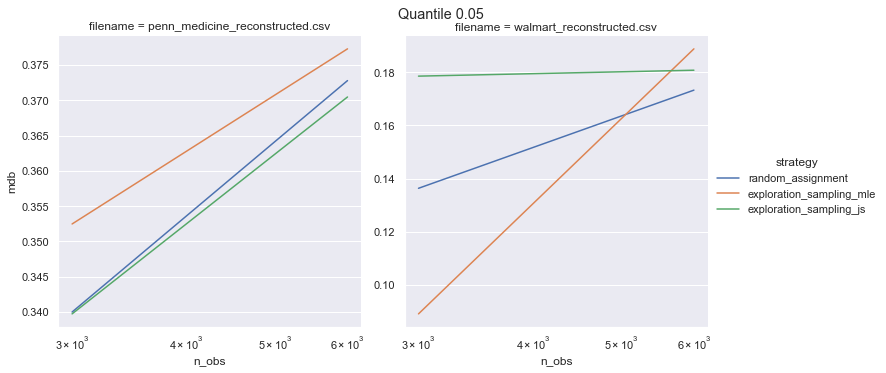

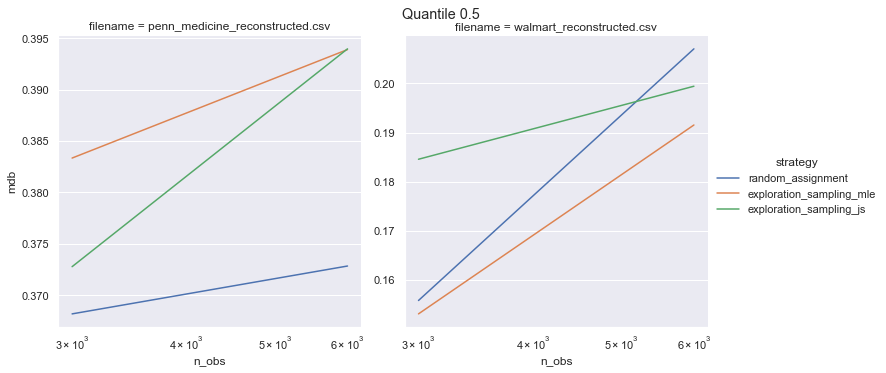

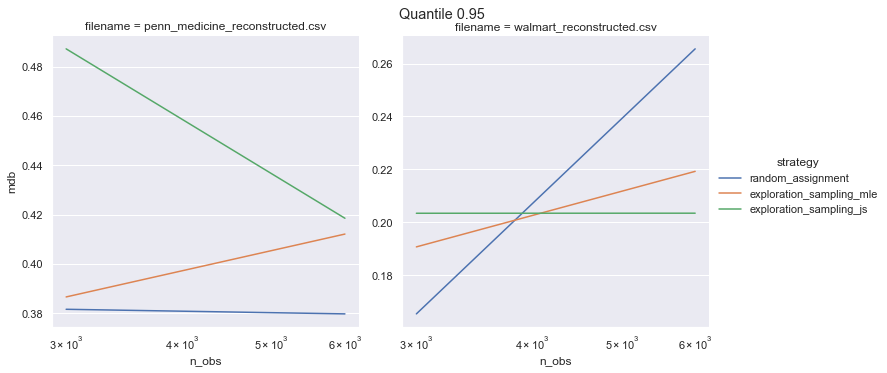

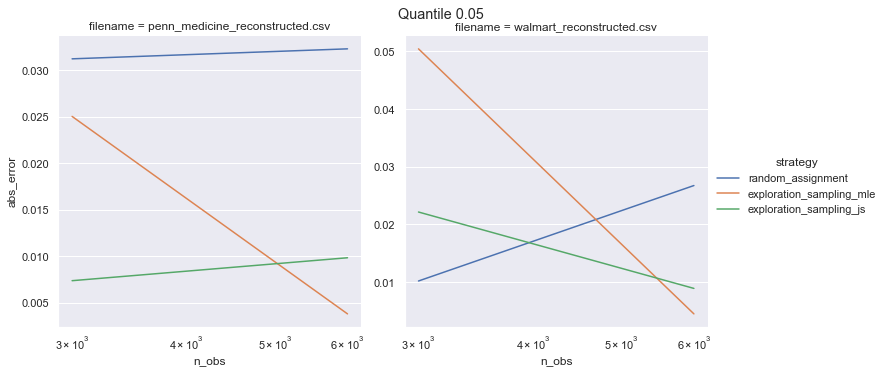

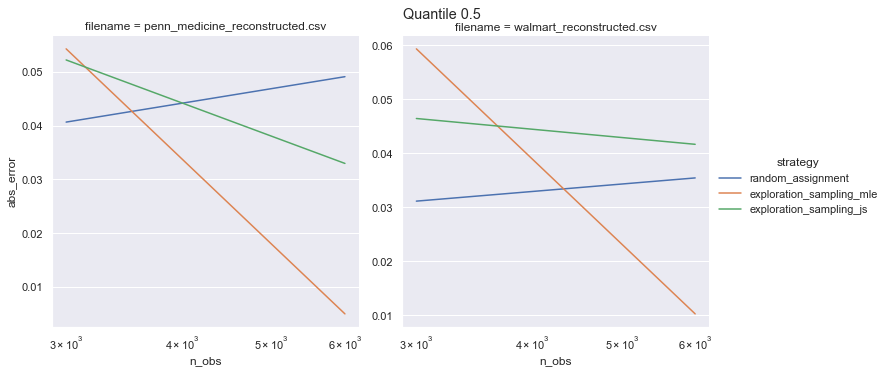

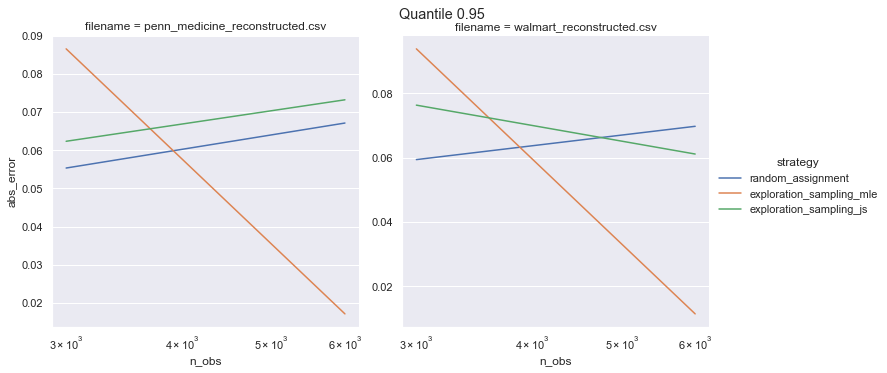

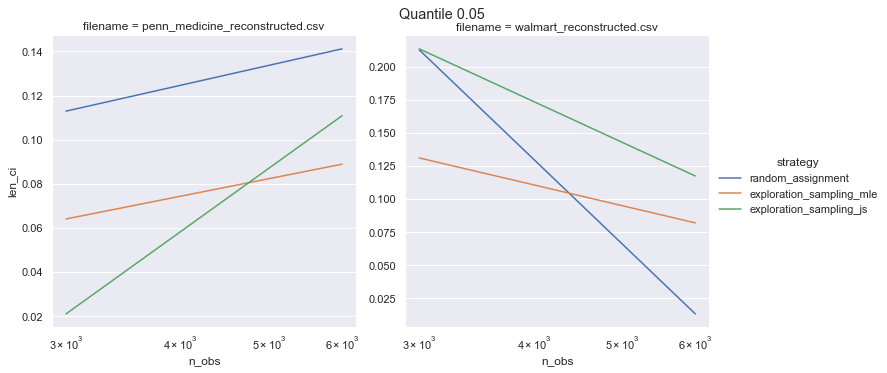

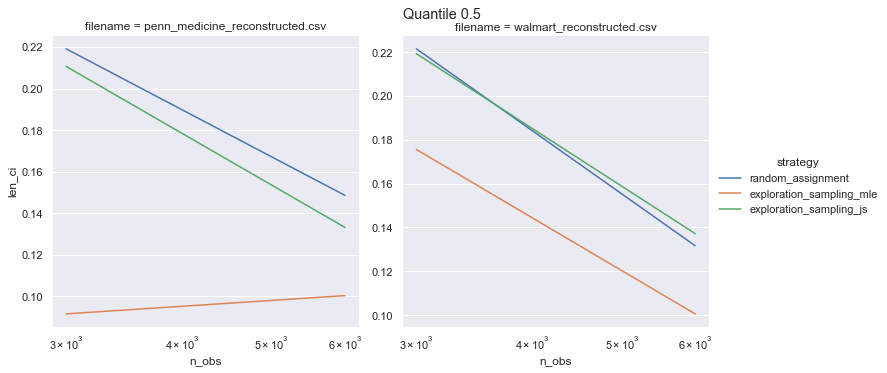

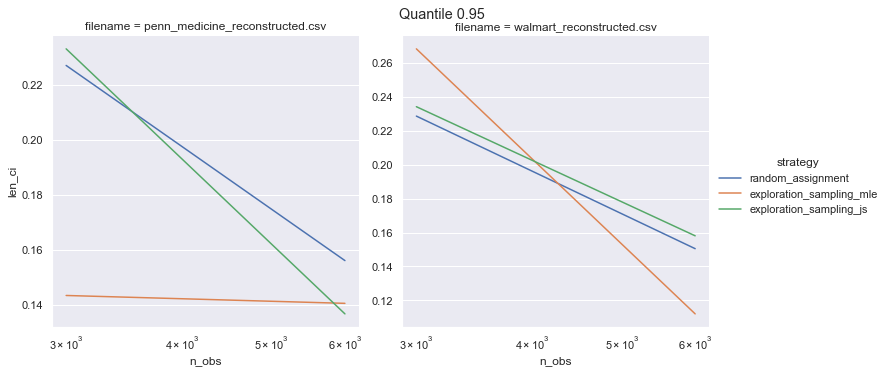

In [35]:
for var, quantile in product(quantile_metrics, (.05, .5, .95)):
    lineplot(var, quantile)
    plt.show()

In [17]:
client.close()